<a href="https://colab.research.google.com/github/changhoonhahn/provabgs/blob/main/nb/nmfburst_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# decorder for `nmfburst` SPS model
Instead of using the PCA encoding a training a neural net to predict PCA coefficients, I'm going to try to train a decoder directly from the (theta, SED) data set. 

notebook has code lifted from: 
- https://github.com/stephenportillo/SDSS-VAE/blob/master/trainVAE.py
- https://github.com/stephenportillo/SDSS-VAE/blob/master/InfoVAE.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/provabgs

/content/drive/My Drive/provabgs


In [3]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

In [4]:
import matplotlib.pyplot as plt

In [5]:
seed = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [6]:
theta = np.load("fsps.nmfburst.theta_unt.test.npy")

In [7]:
# whiten the spectra
mu_lnspec = np.mean(np.load('fsps.nmfburst.lnspectrum.test.npy'), axis=0)
sig_lnspec = np.std(np.load('fsps.nmfburst.lnspectrum.test.npy'), axis=0)

lnspec_white = (np.load('fsps.nmfburst.lnspectrum.test.npy') - mu_lnspec)/sig_lnspec

In [8]:
n_theta = theta.shape[1]
n_lnspec = lnspec_white.shape[1]
print('n theta = %i' % n_theta)
print('n ln(spec) = %i' % n_lnspec)

n theta = 11
n ln(spec) = 4469


In [9]:
Ntrain = int(float(theta.shape[0]) * 0.9)
Ntest = theta.shape[0] - Ntrain
print('Ntrain = %i' % Ntrain)
print('Ntest = %i' % Ntest)

Ntrain = 90000
Ntest = 10000


In [10]:
batch_size=64
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(theta[:Ntrain], dtype=torch.float32), torch.tensor(lnspec_white[:Ntrain], dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True)

In [11]:
class Decoder(nn.Module): 
    def __init__(self, nfeat=1000, ncode=5, nhidden=[15, 30, 100], dropout=0.2):
        super(Decoder, self).__init__()
        
        self.ncode = int(ncode)
        print(nhidden)
        self.dec0 = nn.Linear(ncode, nhidden[0])
        self.dec1 = nn.Linear(nhidden[0], nhidden[1])
        self.dec2 = nn.Linear(nhidden[1], nhidden[2])
        self.outp = nn.Linear(nhidden[2], nfeat)

        self.d0 = nn.Dropout(p=dropout)
        self.d1 = nn.Dropout(p=dropout)
        self.d2 = nn.Dropout(p=dropout)
        
    def decode(self, x):
        x = self.d0(F.leaky_relu(self.dec0(x)))
        x = self.d1(F.leaky_relu(self.dec1(x)))
        x = self.d2(F.leaky_relu(self.dec2(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        return self.decode(x)
    
    def loss(self, x, y):
        recon_y = self.forward(x)
        MSE = torch.sum(0.5 * (y - recon_y).pow(2))
        return MSE

In [12]:
def train(): #model, optimizer, epoch, min_valid_loss, badepochs
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        tt, lns = data
        tt = tt.to(device)
        lns = lns.to(device)

        optimizer.zero_grad()
        
        loss = model.loss(tt, lns)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    return train_loss 

class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')
        
    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

In [13]:
epochs = 200
log_interval = 10
n_config = 1

for config in range(n_config):
    dropout = 0. #0.9*np.random.uniform()
    dfac = 1./(1.-dropout)

    nhidden2 = int(np.ceil(np.exp(np.random.uniform(np.log(100), np.log(dfac*n_lnspec)))))
    nhidden1 = int(np.ceil(np.exp(np.random.uniform(np.log(50), np.log(nhidden2)))))
    nhidden0 = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*n_theta+1), np.log(nhidden1)))))
    print('config %i, dropout = %0.2f; 3 hidden layers with %i,%i,%i nodes' % (config, dropout, nhidden0, nhidden1, nhidden2))
    
    model = Decoder(nfeat=n_lnspec, nhidden=[nhidden0, nhidden1, nhidden2], ncode=n_theta, dropout=dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)
    stopper = EarlyStopper(patience=10)

    for epoch in range(epochs + 1):
        train_loss = train()
        if epoch % 20 == 0:
          print('====> Epoch: {} TRAINING Loss: {:.2e}'.format(epoch, train_loss))

        scheduler.step(train_loss)
        if (not stopper.step(train_loss)) or (epoch == epochs):
            print('Stopping')
            print('====> Epoch: {} TRAINING Loss: {:.2e}'.format(epoch, train_loss))
            #torch.save(model, tag+'/%04i.pth' % config)
            break 
        torch.save(model, 'decoder.pth')
#np.savez(tag+'/metrics.npz', MSE=mdl_MSE, KLD=mdl_KLD, MMD=mdl_MMD)

config 0, dropout = 0.00; 3 hidden layers with 61,72,1306 nodes
[61, 72, 1306]
====> Epoch: 0 TRAINING Loss: 1.35e+02
====> Epoch: 20 TRAINING Loss: 1.26e+01
====> Epoch: 40 TRAINING Loss: 8.12e+00
====> Epoch: 60 TRAINING Loss: 6.24e+00
Epoch    68: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 TRAINING Loss: 2.19e+00
====> Epoch: 100 TRAINING Loss: 1.74e+00
====> Epoch: 120 TRAINING Loss: 1.46e+00
====> Epoch: 140 TRAINING Loss: 1.31e+00
====> Epoch: 160 TRAINING Loss: 1.15e+00
Epoch   180: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 180 TRAINING Loss: 8.21e-01
====> Epoch: 200 TRAINING Loss: 7.64e-01
Stopping
====> Epoch: 200 TRAINING Loss: 7.64e-01


In [24]:
wave = np.load('wave_fsps.npy')

In [15]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(theta[Ntrain:], dtype=torch.float32), torch.tensor(lnspec_white[Ntrain:], dtype=torch.float32)),
    batch_size=Ntest)

In [22]:
with torch.no_grad(): 
  model.eval()
  for test_data in test_loader:
    theta_test, lnspec_white_test = test_data
    theta_test = theta_test.to(device)
    lnspec_white_test = lnspec_white_test.to(device)

    lnspec_white_recon = model.forward(theta_test)

    lnspec_test = sig_lnspec * (lnspec_white_test.cpu().detach().numpy() + mu_lnspec)
    lnspec_recon = sig_lnspec * (lnspec_white_recon.cpu().detach().numpy() + mu_lnspec)

(2305.0, 11025.0)

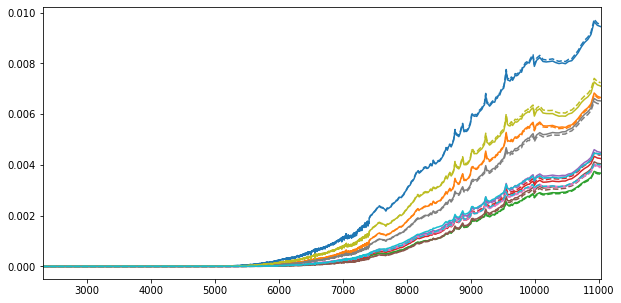

In [34]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii, i in enumerate(np.random.choice(Ntest, size=10, replace=False)): 
  sub.plot(wave, np.exp(lnspec_recon[i]), c='C%i' % ii)
  sub.plot(wave, np.exp(lnspec_test[i]), c='C%i' % ii, ls='--')
sub.set_xlim(wave.min(), wave.max())

(-0.1, 0.1)

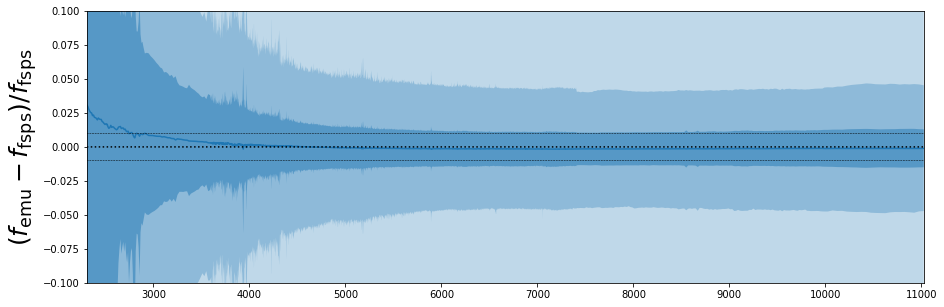

In [27]:
frac_dspectrum = 1. - np.exp(lnspec_recon - lnspec_test)
frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, 
                                          [0.0005, 0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995, 0.9995], axis=0)

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.fill_between(wave, frac_dspectrum_quantiles[0],
        frac_dspectrum_quantiles[-1], fc='C0', ec='none', alpha=0.1, label='99.9%')
sub.fill_between(wave, frac_dspectrum_quantiles[1],
        frac_dspectrum_quantiles[-2], fc='C0', ec='none', alpha=0.2, label='99%')
sub.fill_between(wave, frac_dspectrum_quantiles[2],
        frac_dspectrum_quantiles[-3], fc='C0', ec='none', alpha=0.3, label='95%')
sub.fill_between(wave, frac_dspectrum_quantiles[3],
        frac_dspectrum_quantiles[-4], fc='C0', ec='none', alpha=0.5, label='68%')
sub.plot(wave, frac_dspectrum_quantiles[4], c='C0', ls='-') 
sub.plot(wave, np.zeros(len(wave)), c='k', ls=':') 

# mark +/- 1%
sub.plot(wave, 0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)
sub.plot(wave, -0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)

sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel(r'$(f_{\rm emu} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
sub.set_ylim(-0.1, 0.1)